# SET UP

In [87]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import datetime
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
from keras import layers
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate, Dense, Conv2D, MaxPooling2D, Flatten, Input, Activation, add, AveragePooling2D, BatchNormalization, Dropout
%matplotlib inline
import shutil
import scipy.io
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
import seaborn as sns
from tensorflow.keras.utils import to_categorical

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [2]:
tf.config.list_physical_devices('GPU')

[]

# GET DATA PATH

In [3]:
print(os.getcwd())
for x in range(3):
    os.chdir("..")
print(os.getcwd())

e:\git\HeartResearch\Experiment\Approach\Own model approach
e:\git\HeartResearch


In [4]:
main_data_dir = os.getcwd() + "\\Data set"
print(os.listdir(main_data_dir))

['Label.csv', 'Output', 'Output.png', 'README.md', 'TrainingSet1', 'TrainingSet2', 'TrainingSet3']


In [5]:
data_mat_files = glob(main_data_dir + "/TrainingSet*/*")
print(type(data_mat_files[0]))
print(data_mat_files[0].split('\\'))

<class 'str'>
['e:', 'git', 'HeartResearch', 'Data set', 'TrainingSet1', 'A0001.mat']


In [6]:
label_path = main_data_dir + "/Label.csv"
label_df = pd.read_csv(label_path)
# label_df['First_label'].isnull().any()
print(label_df)

     Recording  First_label  Second_label  Third_label
0        A0001            5           NaN          NaN
1        A0002            1           NaN          NaN
2        A0003            2           NaN          NaN
3        A0004            2           NaN          NaN
4        A0005            7           NaN          NaN
...        ...          ...           ...          ...
6872     A6873            3           NaN          NaN
6873     A6874            8           NaN          NaN
6874     A6875            4           NaN          NaN
6875     A6876            2           NaN          NaN
6876     A6877            7           NaN          NaN

[6877 rows x 4 columns]


In [7]:
print(np.unique(label_df['First_label'].values))

[1 2 3 4 5 6 7 8 9]


In [8]:
mat = scipy.io.loadmat(data_mat_files[0])
print(mat)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Dec 19 16:06:41 2017', '__version__': '1.0', '__globals__': [], 'ECG': array([[(array(['Male'], dtype='<U4'), array([[74]], dtype=uint8), array([[ 0.0282288 ,  0.0392288 ,  0.0452288 , ...,  0.2582288 ,
         0.2592288 ,  0.2592288 ],
       [ 0.00672947,  0.01072947,  0.01472947, ...,  0.24772947,
         0.24872947,  0.24972947],
       [-0.02149933, -0.02849933, -0.03049933, ..., -0.01049933,
        -0.01049933, -0.00949933],
       ...,
       [-0.11200653, -0.11000653, -0.10800653, ...,  0.19399347,
         0.19399347,  0.19499347],
       [-0.5959572 , -0.5899572 , -0.5819572 , ...,  0.3070428 ,
         0.3070428 ,  0.3070428 ],
       [-0.01558507, -0.00658507,  0.00241493, ...,  0.21341493,
         0.21441493,  0.21441493]]))]],
      dtype=[('sex', 'O'), ('age', 'O'), ('data', 'O')])}


In [35]:
def data_extract(signal_raw_list, label_raw, min_len = 3000):
    signal_list = []
    label_list = []
    
    for signal in signal_raw_list:
        mat = scipy.io.loadmat(signal)
        signal_list.append(mat['ECG'][0][0][2][:,:min_len])
        
        signal_number = signal.split('\\')[-1].split('.')[0]
        label_list.append(label_raw[label_raw['Recording'] == signal_number]['First_label'].values[0])
    
    le = preprocessing.LabelEncoder()
    le.fit(label_list)
    labels = le.transform(label_list)
    labels = tf.keras.utils.to_categorical(labels)
    return (np.array(signal_list), np.array(labels), label_list)

In [36]:
signal, label, label_list = data_extract(data_mat_files, label_df)

In [11]:
print(signal.shape)
print(label.shape)

(6877, 12, 3000)
(6877, 9)


In [12]:
train_signal, test_signal, train_label, test_label = train_test_split(signal, label, test_size = 0.2, random_state= 42)

In [13]:
class Model1_LSTM(tf.keras.Model):
    def __init__(self, activation, rate, units_LSTM, units_dense, recurrent_dropout, dropout):
        super(Model1_LSTM, self).__init__()
        unit_dense1, unit_dense2 = units_dense
        act1, act2 = activation
        self.LSTM = layers.LSTM(units=units_LSTM, 
                                activation='tanh', 
                                recurrent_activation='hard_sigmoid', 
                                recurrent_dropout=recurrent_dropout,
                                dropout=dropout)
        self.dense1 = Dense(units=unit_dense1, 
                            activation=act1)
        self.drop = Dropout(rate)
        self.dense2 = Dense(units=unit_dense2,
                            activation=act2)

    def call(self, input):
        x = self.LSTM(input)
        x = self.dense1(x)
        x = self.drop(x)
        x = self.dense2(x)

        return x

In [14]:
basemodel = Model1_LSTM(units_dense = (64, 9), 
                        activation = ('relu', 'softmax'), 
                        rate = 0.5, 
                        units_LSTM= 64, 
                        recurrent_dropout= 0.2, 
                        dropout=0.2)
                        
Input = tf.keras.Input(shape= (12,3000))
# input = train_signal
output = basemodel(Input)
model = tf.keras.Model(Input, output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 3000)]        0         
                                                                 
 model1_lstm (Model1_LSTM)   (None, 9)                 789385    
                                                                 
Total params: 789,385
Trainable params: 789,385
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(optimizer='adam', loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics = 'accuracy')

In [16]:
model.fit(train_signal, train_label, epochs=10)

Epoch 1/10
172/172 [==============================] - 14s 67ms/step - loss: 2.1292 - accuracy: 0.1976
Epoch 2/10
172/172 [==============================] - 10s 61ms/step - loss: 1.9500 - accuracy: 0.2816
Epoch 3/10
172/172 [==============================] - 10s 57ms/step - loss: 1.8011 - accuracy: 0.3398
Epoch 4/10
172/172 [==============================] - 10s 57ms/step - loss: 1.5898 - accuracy: 0.4303
Epoch 5/10
172/172 [==============================] - 10s 57ms/step - loss: 1.3487 - accuracy: 0.5261
Epoch 6/10
172/172 [==============================] - 10s 57ms/step - loss: 1.0899 - accuracy: 0.6357
Epoch 7/10
172/172 [==============================] - 10s 56ms/step - loss: 0.8741 - accuracy: 0.7151
Epoch 8/10
172/172 [==============================] - 10s 57ms/step - loss: 0.6742 - accuracy: 0.7820
Epoch 9/10
172/172 [==============================] - 10s 56ms/step - loss: 0.5304 - accuracy: 0.8360
Epoch 10/10
172/172 [==============================] - 10s 57ms/step - loss: 0.433

In [17]:
prediction = model.predict(test_signal)
print(type(prediction))
print(prediction.shape)

<class 'numpy.ndarray'>
(1376, 9)


In [18]:
print(classification_report(np.argmax(test_label,axis=1),np.argmax(prediction, axis=1)))

              precision    recall  f1-score   support

           0       0.29      0.29      0.29       192
           1       0.19      0.15      0.17       230
           2       0.12      0.14      0.13       135
           3       0.21      0.12      0.15        42
           4       0.31      0.34      0.33       344
           5       0.13      0.13      0.13       102
           6       0.16      0.17      0.17       128
           7       0.16      0.18      0.17       160
           8       0.07      0.05      0.06        43

    accuracy                           0.22      1376
   macro avg       0.18      0.17      0.18      1376
weighted avg       0.22      0.22      0.22      1376



<AxesSubplot: >

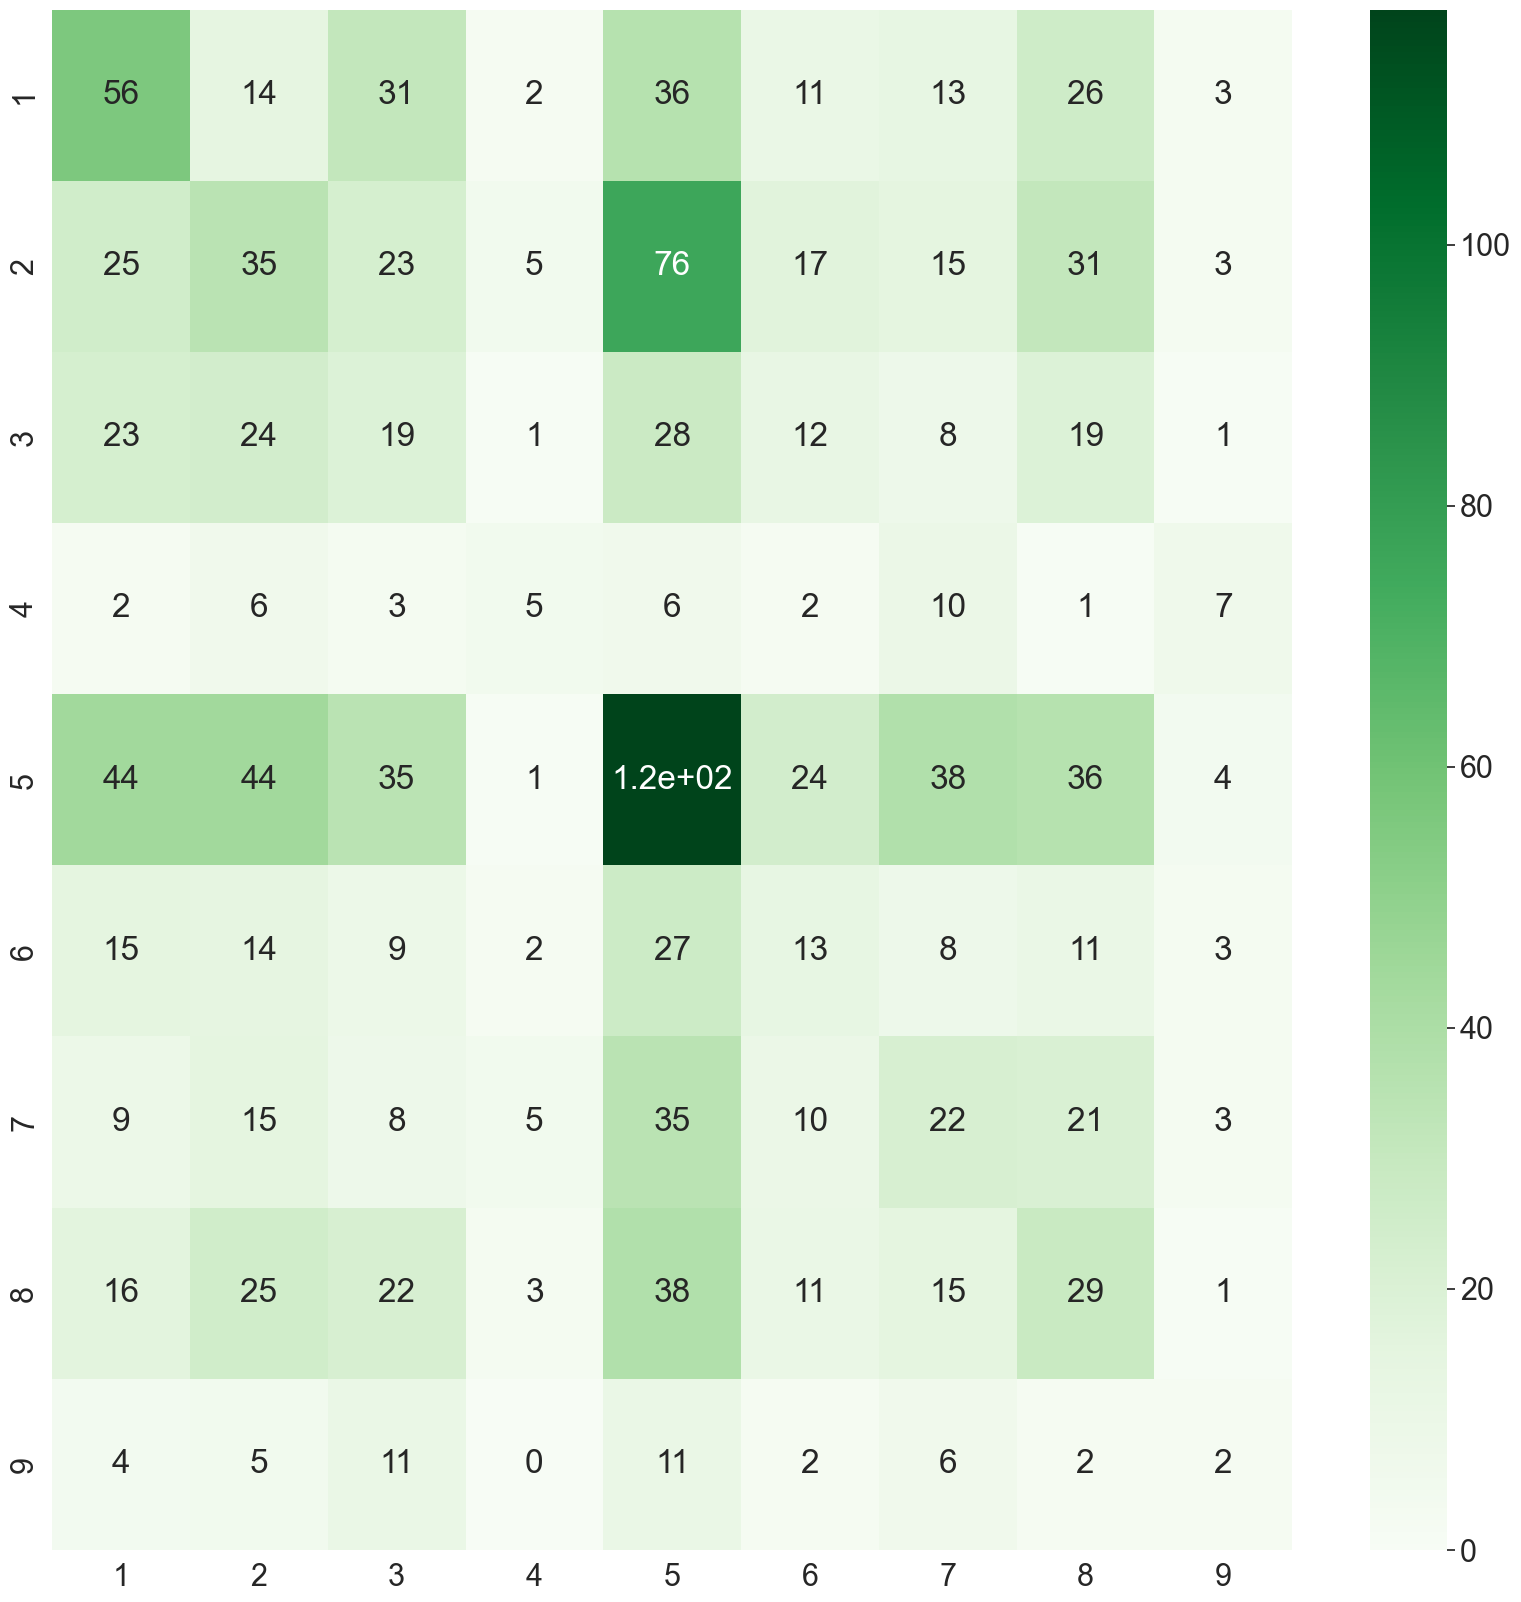

In [19]:
targetnames = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
sns.set(font_scale=2)
# from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
# multi_cm = multilabel_confusion_matrix(y_true, y_pred)
cm = confusion_matrix(np.argmax(test_label,axis=1),np.argmax(prediction, axis=1))
df_cm = pd.DataFrame(cm, index = targetnames, columns = targetnames)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True, cmap = "Greens")

In [20]:
def cm_compute(_cm, index, _name):
    print("Confusion Matrix of {}".format(_name))
    print(_cm[index])
    TP = _cm[index][1][1]
    FP = _cm[index][0][1]
    FN = _cm[index][1][0]
    TN = _cm[index][0][0]
    print("True Positive of {0}: {1}".format(_name, TP))
    print("False Positive of {0}: {1}".format(_name, FP))
    print("False Negative of {0}: {1}".format(_name, FN))
    print("True Negative of {0}: {1}".format(_name, TN))
    sensitivity = TP/(TP + FN)
    specificity = TN/(TN + FP)
    print("Sensitivity of {0}: {1}".format(_name, sensitivity))
    print("Specificity of {0}: {1}".format(_name, specificity))
    print("Precision of {0}: {1}".format(_name, TP/(TP + FP)))
    print("Accuracy of {0}: {1}".format(_name, (TP+TN)/(TP + FP + FN + TN)))
    print("Balanced Accuracy of {0} : {1}".format(_name, (sensitivity + specificity)/2))
    print("F1 Score of {0}: {1}".format(_name, (2*TP)/(2*TP + FP + FN)))

In [21]:
multi_cm = multilabel_confusion_matrix(np.argmax(test_label,axis=1),np.argmax(prediction, axis=1))

In [22]:
index = 0
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of 1
[[1046  138]
 [ 136   56]]
True Positive of 1: 56
False Positive of 1: 138
False Negative of 1: 136
True Negative of 1: 1046
Sensitivity of 1: 0.2916666666666667
Specificity of 1: 0.8834459459459459
Precision of 1: 0.28865979381443296
Accuracy of 1: 0.8008720930232558
Balanced Accuracy of 1 : 0.5875563063063063
F1 Score of 1: 0.29015544041450775


In [23]:
index = 1
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of 2
[[999 147]
 [195  35]]
True Positive of 2: 35
False Positive of 2: 147
False Negative of 2: 195
True Negative of 2: 999
Sensitivity of 2: 0.15217391304347827
Specificity of 2: 0.8717277486910995
Precision of 2: 0.19230769230769232
Accuracy of 2: 0.751453488372093
Balanced Accuracy of 2 : 0.5119508308672889
F1 Score of 2: 0.16990291262135923


In [24]:
index = 2
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of 3
[[1099  142]
 [ 116   19]]
True Positive of 3: 19
False Positive of 3: 142
False Negative of 3: 116
True Negative of 3: 1099
Sensitivity of 3: 0.14074074074074075
Specificity of 3: 0.8855761482675262
Precision of 3: 0.11801242236024845
Accuracy of 3: 0.8125
Balanced Accuracy of 3 : 0.5131584445041335
F1 Score of 3: 0.12837837837837837


In [25]:
index = 3
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of 4
[[1315   19]
 [  37    5]]
True Positive of 4: 5
False Positive of 4: 19
False Negative of 4: 37
True Negative of 4: 1315
Sensitivity of 4: 0.11904761904761904
Specificity of 4: 0.9857571214392804
Precision of 4: 0.20833333333333334
Accuracy of 4: 0.9593023255813954
Balanced Accuracy of 4 : 0.5524023702434497
F1 Score of 4: 0.15151515151515152


In [26]:
index = 4
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of 5
[[775 257]
 [226 118]]
True Positive of 5: 118
False Positive of 5: 257
False Negative of 5: 226
True Negative of 5: 775
Sensitivity of 5: 0.3430232558139535
Specificity of 5: 0.750968992248062
Precision of 5: 0.31466666666666665
Accuracy of 5: 0.6489825581395349
Balanced Accuracy of 5 : 0.5469961240310077
F1 Score of 5: 0.3282336578581363


In [27]:
index = 5
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of 6
[[1185   89]
 [  89   13]]
True Positive of 6: 13
False Positive of 6: 89
False Negative of 6: 89
True Negative of 6: 1185
Sensitivity of 6: 0.12745098039215685
Specificity of 6: 0.9301412872841445
Precision of 6: 0.12745098039215685
Accuracy of 6: 0.8706395348837209
Balanced Accuracy of 6 : 0.5287961338381506
F1 Score of 6: 0.12745098039215685


In [28]:
index = 6
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of 7
[[1135  113]
 [ 106   22]]
True Positive of 7: 22
False Positive of 7: 113
False Negative of 7: 106
True Negative of 7: 1135
Sensitivity of 7: 0.171875
Specificity of 7: 0.9094551282051282
Precision of 7: 0.16296296296296298
Accuracy of 7: 0.840843023255814
Balanced Accuracy of 7 : 0.5406650641025641
F1 Score of 7: 0.16730038022813687


In [29]:
index = 7
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of 8
[[1069  147]
 [ 131   29]]
True Positive of 8: 29
False Positive of 8: 147
False Negative of 8: 131
True Negative of 8: 1069
Sensitivity of 8: 0.18125
Specificity of 8: 0.8791118421052632
Precision of 8: 0.16477272727272727
Accuracy of 8: 0.7979651162790697
Balanced Accuracy of 8 : 0.5301809210526316
F1 Score of 8: 0.17261904761904762


In [30]:
index = 8
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of 9
[[1308   25]
 [  41    2]]
True Positive of 9: 2
False Positive of 9: 25
False Negative of 9: 41
True Negative of 9: 1308
Sensitivity of 9: 0.046511627906976744
Specificity of 9: 0.981245311327832
Precision of 9: 0.07407407407407407
Accuracy of 9: 0.9520348837209303
Balanced Accuracy of 9 : 0.5138784696174044
F1 Score of 9: 0.05714285714285714


In [71]:
print("Precision: "+ str(precision_score(np.argmax(test_label,axis=1),np.argmax(prediction, axis=1), average='weighted')))
print("Recall: "+ str(recall_score(np.argmax(test_label,axis=1),np.argmax(prediction, axis=1), average='weighted')))
print("Accuracy: " + str(accuracy_score(np.argmax(test_label,axis=1),np.argmax(prediction, axis=1))))
print("weighted Roc score: " + str(roc_auc_score(np.argmax(test_label,axis=1),np.argmax(prediction, axis=1), multi_class='ovo', average='weighted')))

Precision: 0.21510795116510753
Recall: 0.21729651162790697
Accuracy: 0.21729651162790697


AxisError: axis 1 is out of bounds for array of dimension 1

In [90]:
print("Precision: "+ str(precision_score(np.argmax(test_label,axis=1),np.argmax(prediction, axis=1), average='macro')))
print("Recall: "+ str(recall_score(np.argmax(test_label,axis=1),np.argmax(prediction, axis=1), average='macro')))
print("Accuracy: " + str(accuracy_score(np.argmax(test_label,axis=1),np.argmax(prediction, axis=1))))
print("weighted Roc score: " + str(roc_auc_score(test_label, to_categorical(np.argmax(prediction,axis=1)),average='macro')))

Precision: 0.18347118368714385
Recall: 0.17485997817906576
Accuracy: 0.21729651162790697
weighted Roc score: 0.5361760738403264


In [33]:
from tensorflow.keras.utils import to_categorical
print("Precision: "+ str(precision_score(np.argmax(test_label,axis=1),np.argmax(prediction, axis=1), average='micro')))
print("Recall: "+ str(recall_score(np.argmax(test_label,axis=1),np.argmax(prediction, axis=1), average='micro')))
print("Accuracy: " + str(accuracy_score(np.argmax(test_label,axis=1),np.argmax(prediction, axis=1))))
tpr={}
fpr={}
roc_auc={}
fpr["micro"], tpr["micro"], _ = roc_curve(to_categorical(np.argmax(test_label, axis=1)).ravel(), to_categorical(np.argmax(prediction, axis=1)).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro Roc score: " + str(roc_auc["micro"]))

Precision: 0.21729651162790697
Recall: 0.21729651162790697
Accuracy: 0.21729651162790697
Micro Roc score: 0.5597292877906976


In [66]:
print(test_label)
print(prediction)

[[0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[9.6582016e-03 4.0103169e-03 6.5192371e-03 ... 9.1433162e-03
  1.4207838e-03 4.9281280e-05]
 [6.0567093e-01 5.9606908e-03 7.5403713e-02 ... 1.1574770e-02
  1.9639792e-02 4.4780344e-04]
 [2.4594532e-04 1.0023989e-03 2.4913546e-02 ... 8.2718712e-01
  1.1478672e-02 8.1579007e-02]
 ...
 [2.5967675e-01 5.9595373e-02 1.5215432e-02 ... 9.5078860e-05
  8.7968627e-05 1.2446644e-03]
 [3.4479793e-02 8.2639948e-04 8.5078724e-02 ... 6.2465866e-04
  8.7654769e-01 1.1029546e-03]
 [6.0159254e-01 1.5713772e-03 1.6763571e-01 ... 4.9450691e-04
  3.0684654e-04 1.8611662e-02]]


In [92]:
print(np.argmax(test_label,axis=1))
# print(type(np.argmax(test_label,axis=1)))
print(np.argmax(prediction,axis=1))
# print(type(np.argmax(test_label,axis=1).tolist()))
print(to_categorical(np.argmax(prediction, axis=1)))

[2 0 7 ... 5 5 4]
[4 0 6 ... 4 7 0]
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [78]:
n = 10000
ratio = .95
n_0 = int((1-ratio) * n)
n_1 = int(ratio * n)

y = np.array([0] * n_0 + [1] * n_1)
# below are the probabilities obtained from a hypothetical model that always predicts the majority class
# probability of predicting class 1 is going to be 100%
y_proba = np.array([1]*n)
y_pred = y_proba > .5

In [80]:
print(y)
print(y_proba)
print(roc_auc_score(y, y_proba))

[0 0 0 ... 1 1 1]
[1 1 1 ... 1 1 1]
0.5


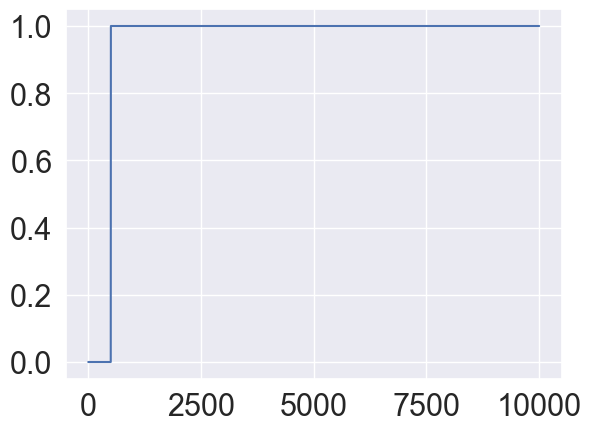

In [41]:
plt.plot(y)

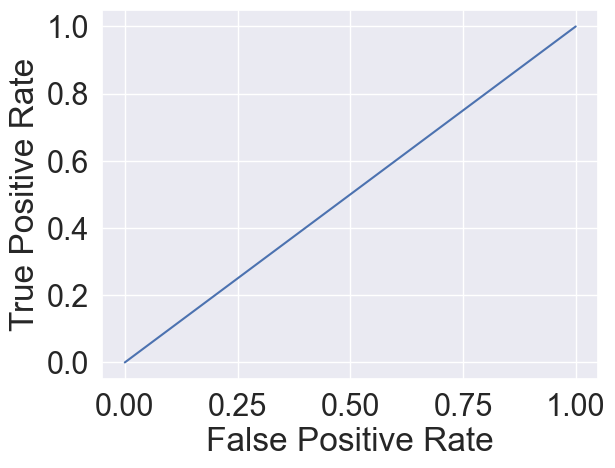

In [42]:
plot_roc_curve(y, y_proba)

In [82]:
x = [0,1,1,0,1,0]
y = [0,1,0,1,1,0]
roc_auc_score(x,y
        )

0.6666666666666667